In [1]:
from WingWatch.Intersections.detection import Detection
from WingWatch.Intersections import tri
import trimesh
import pandas as pd
import numpy as np
import WingWatch.Intersections.physicalTrackLimiter as PTL
from WingWatch.Equipment import station
from WingWatch.Equipment import antenna
from WingWatch.Tools import translation,spheres
from WingWatch.Tools import point_check as pc
import matplotlib.pyplot as plt
import scipy.spatial as ss

test_data_file = 'Fake_Calibration_Data.csv'
df = pd.read_csv(test_data_file)


Station_1 = station.Station('Station_1',41.1479, -71.5901)
Station_1_Comp_Data = pd.read_csv(test_data_file)
Station_2_pos = translation.convert_back_to_lla([0,-200,0],Station_1.lat,Station_1.long,Station_1.alt)
Station_3_pos = translation.convert_back_to_lla([100*np.sqrt(3),-100,0],Station_1.lat,Station_1.long,Station_1.alt)


freq_of_antenna_MHz = 434
antenna_number = '1'
antenna_type = 'test'
bearing_of_antenna = 0 


a1 = antenna.Antenna(antenna_number,antenna_type,bearing_of_antenna,freq_of_antenna_MHz)
a1.assign_pattern(Station_1_Comp_Data)
Station_1.add_antenna(a1)

Station_2 = station.Station('Station_2',Station_2_pos[0], Station_2_pos[1])
Station_2_Comp_Data = pd.read_csv(test_data_file)


a1 = antenna.Antenna(antenna_number,antenna_type,bearing_of_antenna,freq_of_antenna_MHz)
a1.assign_pattern(Station_2_Comp_Data)
Station_2.add_antenna(a1)




Station_3 = station.Station('Station_3',Station_3_pos[0], Station_3_pos[1])
Station_3_Comp_Data = pd.read_csv(test_data_file)

a1 = antenna.Antenna(antenna_number,antenna_type,bearing_of_antenna,freq_of_antenna_MHz)
a1.assign_pattern(Station_3_Comp_Data)
Station_3.add_antenna(a1)


1 added to Station_1's antennas.
1 added to Station_2's antennas.
1 added to Station_3's antennas.


In [2]:
df_detections = pd.read_csv('straight_walk_Detections.csv')
df_walk = pd.read_csv('straight_walk.csv')


#first step, generate all of the single point detections
g = 0 
points_to_follow = []
cx_cent = []
cy_cent = []
for i in range(len(df_detections['Station 1'])):
    det1 = Detection(Station_1,df_detections['Station 1'][i],1)
    det2 = Detection(Station_2,df_detections['Station 2'][i],1)
    det3 = Detection(Station_3,df_detections['Station 3'][i],1)
    data_to_send_through = [det1,det2,det3]
    intersections,hull_of_intersections = tri.overlap_of_three_radiation_patterns(data_to_send_through)
    points_to_follow.append(intersections)
    cx = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,0])
    cy = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,1])
    cz = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,2])
    cx_cent.append(cx)
    cy_cent.append(cy)
    g += pc.point_in_hull(np.array([df_walk.iloc[i].X,df_walk.iloc[i].Y,df_walk.iloc[i].Z]),hull_of_intersections,tolerance=2.5)


#g should be the same value as the len of the detections

In [3]:
import WingWatch.Tools.spheres as sph

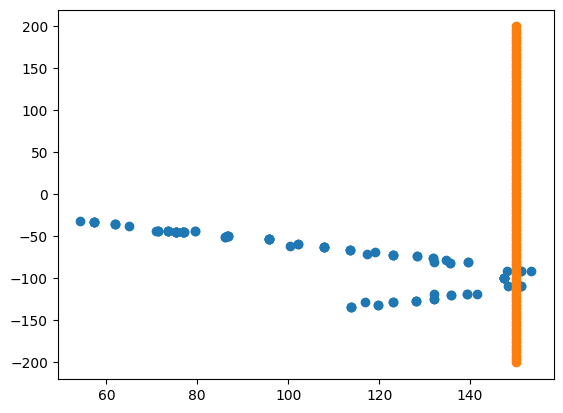

In [4]:
plt.scatter(cx_cent,cy_cent)
plt.scatter(df_walk.X,df_walk.Y)

In [5]:
cx_appv = cx_cent[0:3]
cy_appv = cy_cent[0:3]

radius_list_oldest = []
for i in range(len(points_to_follow)):
    V = ss.ConvexHull(points_to_follow[i]).volume
    radius = sph.find_radius_from_vol(V)
    radius_list_oldest.append(radius)


In [6]:
cx_new = []
cy_new = []
points_to_follow_new = [points_to_follow[0]]
cx_new.append(cx_cent[0])
cy_new.append(cy_cent[0])

i = 1

intersections,hull_of_intersections = PTL.check_constraints(points_to_follow[i-1],points_to_follow[i],16,i)
points_to_follow_new.append(intersections)


radius_list = []
for i in range(len(points_to_follow_new)):
    V = ss.ConvexHull(points_to_follow_new[i]).volume
    radius = sph.find_radius_from_vol(V)
    radius_list.append(radius)


In [7]:
radius_list

[188.00059496131922, 180.67476851744553]

In [8]:
cx_new = []
cy_new = []
points_to_follow_new = []

for i in range(len(points_to_follow)):
    if i == 0: 
        cx_new.append(cx_cent[i])
        cy_new.append(cy_cent[i])
        points_to_follow_new.append(points_to_follow[i])
        continue
    intersections,hull_of_intersections = PTL.check_constraints(points_to_follow_new[i-1],points_to_follow[i],5,1)
    points_to_follow_new.append(intersections)
    cx = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,0])
    cy = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,1])
    cx_new.append(cx)
    cy_new.append(cy)

In [9]:
# import numpy as np
# from scipy.spatial import ConvexHull
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# import plotly.graph_objects as go

# # Generate random points in 3D
# points = hull_of_intersections.points  # 30 random points in 3D

# # Compute the convex hull
# hull = ss.ConvexHull(points)

# fig = go.Figure()

# # Add the points        for j in range(len(station_data[i][0])):

# fig.add_trace(go.Scatter3d(
#     x=intersections[:, 0], y=intersections[:, 1], z=intersections[:, 2],
#     mode='markers',
#     marker=dict(size=5, color='blue'),
#     name='Points'
# ))

# # Add the convex hull
# for simplex in hull.simplices:
#     fig.add_trace(go.Mesh3d(
#         x=intersections[simplex, 0],
#         y=intersections[simplex, 1],
#         z=intersections[simplex, 2],
#         color='cyan',
#         opacity=0.5,
#         name='Convex Hull'
#     ))

# # Add a specific point (321, -12, 29) in red
# fig.add_trace(go.Scatter3d(
#     x=[321], y=[-12], z=[29],
#     mode='markers',
#     marker=dict(size=10, color='red'),
#     name='Special Point'
# ))

# # Set the title and labels
# fig.update_layout(
#     title='3D Convex Hull',
#     scene=dict(
#         xaxis_title='X',
#         yaxis_title='Y',
#         zaxis_title='Z'
#     )
# )

# # Show plot
# fig.show()

In [10]:
radius_list = []
for i in range(len(points_to_follow_new)):
    V = ss.ConvexHull(points_to_follow_new[i],qhull_options='Q12').volume
    radius = sph.find_radius_from_vol(V)
    radius_list.append(radius)

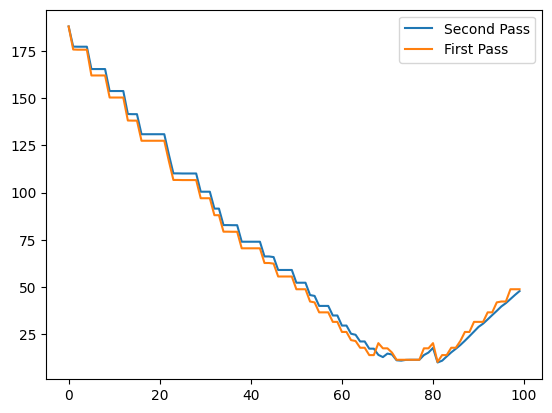

In [11]:
plt.plot(radius_list,label='Second Pass')
plt.plot(radius_list_oldest,label='First Pass')
plt.legend()

In [12]:
cx_new = []
cy_new = []
points_to_follow_three = []

for i in range(len(points_to_follow)):
    if i == 0 or i == 1: 
        cx_new.append(cx_cent[i])
        cy_new.append(cy_cent[i])
        points_to_follow_three.append(points_to_follow[i])
        continue
    intersections,hull_of_intersections = PTL.check_constraints_two_region(points_to_follow_three[i-2],points_to_follow_three[i-1],points_to_follow[i],5,1)
    points_to_follow_three.append(intersections)
    cx = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,0])
    cy = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,1])
    cx_new.append(cx)
    cy_new.append(cy)

In [13]:
len(points_to_follow)

100

In [14]:
radius_list_3 = []
for i in range(len(points_to_follow_three)):
    V = ss.ConvexHull(points_to_follow_three[i],qhull_options='Q12').volume
    radius = sph.find_radius_from_vol(V)
    radius_list_3.append(radius)

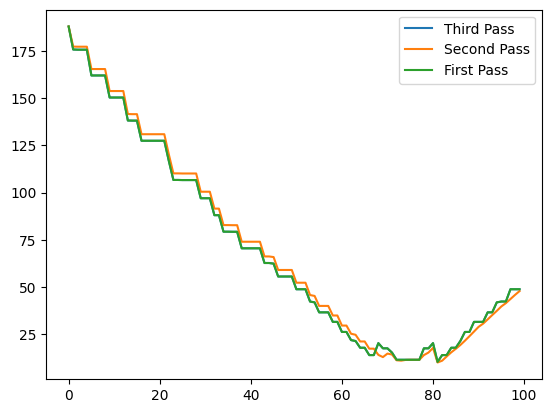

In [15]:
plt.plot(radius_list_3,label='Third Pass')
plt.plot(radius_list,label='Second Pass')
plt.plot(radius_list_oldest,label='First Pass')
plt.legend()

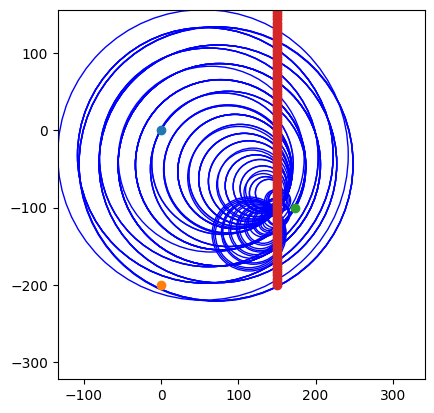

In [16]:
import matplotlib.pyplot as plt

df_walk = pd.read_csv('straight_walk.csv')



# Example coordinates and radii
x_coords = cx_cent
y_coords = cy_cent
radii = radius_list

# Create a figure and axis
fig, ax = plt.subplots()

# Plot each circle
for x, y, radius in zip(x_coords, y_coords, radii):
    circle = plt.Circle((x, y), radius, edgecolor='blue', facecolor='none')  # Create a circle
    ax.add_patch(circle)  # Add the circle to the plot

# Set axis limits (for proper circle display)
ax.set_xlim(min(x_coords) - max(radii), max(x_coords) + max(radii))
ax.set_ylim(min(y_coords) - max(radii), max(y_coords) + max(radii))
ax.set_aspect('equal', 'box')  # Ensure the aspect ratio is equal


plt.scatter(0,0,label='Station 1')
plt.scatter(0,-200,label='Station 2')
plt.scatter(100*np.sqrt(3),-100,label='Station 3')
plt.scatter(df_walk.X,df_walk.Y, label='Detection Walk')


# Show plot
plt.show()

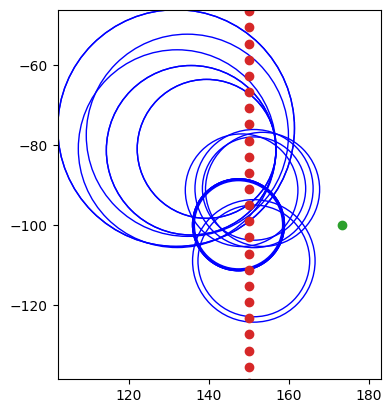

In [17]:
import matplotlib.pyplot as plt

df_walk = pd.read_csv('straight_walk.csv')



# Example coordinates and radii
x_coords = cx_cent[60:80]
y_coords = cy_cent[60:80]
radii = radius_list[60:80]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot each circle
for x, y, radius in zip(x_coords, y_coords, radii):
    circle = plt.Circle((x, y), radius, edgecolor='blue', facecolor='none')  # Create a circle
    ax.add_patch(circle)  # Add the circle to the plot

# Set axis limits (for proper circle display)
ax.set_xlim(min(x_coords) - max(radii), max(x_coords) + max(radii))
ax.set_ylim(min(y_coords) - max(radii), max(y_coords) + max(radii))
ax.set_aspect('equal', 'box')  # Ensure the aspect ratio is equal


plt.scatter(0,0,label='Station 1')
plt.scatter(0,-200,label='Station 2')
plt.scatter(100*np.sqrt(3),-100,label='Station 3')
plt.scatter(df_walk.X,df_walk.Y, label='Detection Walk')


# Show plot
plt.show()

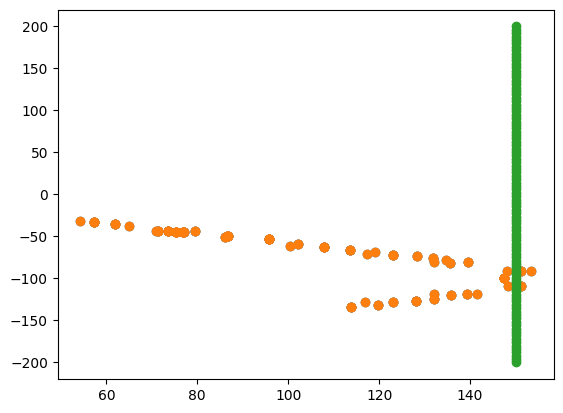

In [18]:
plt.scatter(cx_cent,cy_cent)
plt.scatter(cx_new,cy_new)
plt.scatter(df_walk.X,df_walk.Y)

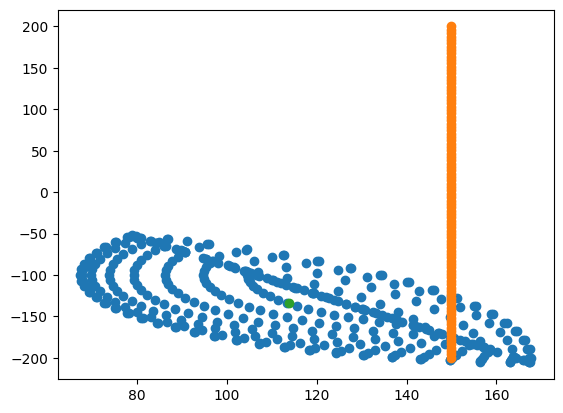

In [19]:
plt.scatter(intersections[:,0],intersections[:,1])

cx = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,0])
cy = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,1])

#plt.scatter(cx_cent,cy_cent)
plt.scatter(df_walk.X,df_walk.Y)

plt.scatter(cx,cy)

In [20]:
cx_new = []
cy_new = []
points_to_follow_new = []

for i in range(71,len(points_to_follow)):
    #for i in range(3):
    if i == 0: 
        cx_new.append(cx_cent[i])
        cy_new.append(cy_cent[i])
        continue
    intersections,hull_of_intersections = PTL.check_constraints(points_to_follow[i-1],points_to_follow[i],5,i)
    points_to_follow_new.append(intersections)
    cx = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,0])
    cy = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,1])
    cx_new.append(cx)
    cy_new.append(cy)

In [21]:
radius_list_new = []
for i in range(len(points_to_follow_new)):
    V = ss.ConvexHull(points_to_follow_new[i],qhull_options='Q12').volume
    radius = sph.find_radius_from_vol(V)
    radius_list_new.append(radius)

In [22]:
radius_list_new

[17.553982440037018,
 15.283232653281468,
 11.493381457558138,
 11.493381457558138,
 11.493381457558138,
 11.493381457558138,
 11.493381457558138,
 17.55406743945962,
 17.55406743945962,
 20.304208034648088,
 20.304208034648088,
 13.967856927052706,
 13.967856810856475,
 17.859579612373317,
 17.859579612373317,
 21.42890734173082,
 26.228755529847902,
 26.228755529847902,
 31.566724490980796,
 31.566724490980796,
 31.566724490980796,
 36.60863493193926,
 36.60863493193926,
 41.88493415115459,
 42.34383205227181,
 42.34383205227181,
 48.844566017945475,
 48.844566017945475,
 48.844566017945475]

In [23]:
radius_list_new

[17.553982440037018,
 15.283232653281468,
 11.493381457558138,
 11.493381457558138,
 11.493381457558138,
 11.493381457558138,
 11.493381457558138,
 17.55406743945962,
 17.55406743945962,
 20.304208034648088,
 20.304208034648088,
 13.967856927052706,
 13.967856810856475,
 17.859579612373317,
 17.859579612373317,
 21.42890734173082,
 26.228755529847902,
 26.228755529847902,
 31.566724490980796,
 31.566724490980796,
 31.566724490980796,
 36.60863493193926,
 36.60863493193926,
 41.88493415115459,
 42.34383205227181,
 42.34383205227181,
 48.844566017945475,
 48.844566017945475,
 48.844566017945475]

In [24]:
radius_list[70:]

[14.774174523151764,
 14.274098799519631,
 11.226267567100797,
 11.035520158377388,
 11.420652811577815,
 11.493215572036354,
 11.493381457558138,
 11.493381457558138,
 13.971435961215445,
 15.320831238543363,
 17.776103433265337,
 10.062962154502657,
 11.003667955647384,
 13.229195254396675,
 15.420815046458374,
 17.29934269921481,
 19.305750138947744,
 21.579473765645833,
 23.974659816954365,
 26.43347038410147,
 28.91799789016619,
 30.633108627501297,
 32.86835589554712,
 35.162533565843916,
 37.39533297213261,
 39.72724215228639,
 41.499724237824715,
 43.65336535129781,
 45.834173224115894,
 47.875086870826756]

In [25]:
radius_list_oldest[70:]

[17.553982440037018,
 15.283232653281468,
 11.493381457558138,
 11.493381457558138,
 11.493381457558138,
 11.493381457558138,
 11.493381457558138,
 11.493381457558138,
 17.55406743945962,
 17.55406743945962,
 20.304208034648088,
 10.343539900434283,
 13.967856927052706,
 13.967856927052706,
 17.85957961237332,
 17.85957961237332,
 21.428907391099504,
 26.228755529847902,
 26.228755529847902,
 31.566724513731373,
 31.566724513731373,
 31.566724513731373,
 36.60863493193926,
 36.60863493193926,
 41.884934152954926,
 42.34383205893604,
 42.34383205893604,
 48.844566028625735,
 48.844566028625735,
 48.844566028625735]